## Feature Engineering

### Importing Libraries

In [2]:
#loading libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import os


#overriding default setting of pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Importing datasets

In [3]:
root = '/instacart-market-basket-analysis/'

In [4]:
aisles = pd.read_csv(os.getcwd() + root + 'aisles.csv')
departments = pd.read_csv(os.getcwd() + root + 'departments.csv')
orders = pd.read_csv(os.getcwd() + root + 'orders.csv')
prior_order = pd.read_csv(os.getcwd() + root + 'order_products__prior.csv')
train_order = pd.read_csv(os.getcwd() + root + 'order_products__train.csv')
products = pd.read_csv(os.getcwd() + root + 'products.csv')

#imputation
orders.fillna(value = 0, inplace = True)

In [4]:
#prior_train_orders = pd.concat([prior_order, train_order]).sort_values(by=['order_id'])

#Merge all files together
prior_orders_data = prior_order.sort_values(by=['order_id'])
prior_orders_data = pd.merge(left = prior_orders_data, right = products,
                             left_on='product_id', right_on='product_id').sort_values(by=['order_id']).reset_index(drop=True)
prior_orders_data = pd.merge(left = prior_orders_data, right = aisles,
                             left_on='aisle_id', right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)
prior_orders_data = pd.merge(left = prior_orders_data, right = departments,
                             left_on='department_id', right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)
prior_orders_data = pd.merge(left = prior_orders_data, right = orders,
                             left_on='order_id', right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)

col_order = ['user_id',
 'order_id',
 'product_id',
  'aisle_id',
 'department_id',
 'add_to_cart_order',
 'reordered',
 'product_name',
 'aisle',
 'department',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order']

prior_orders_data = prior_orders_data[col_order]
print("Shape of prior_orders_data :", prior_orders_data.shape)
prior_orders_data.head()

Shape of prior_orders_data : (32434489, 15)


,user_id,order_id,product_id,aisle_id,department_id,add_to_cart_order,reordered,product_name,aisle,department,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,202279,2,33120,86,16,1,1,Organic Egg Whites,eggs,dairy eggs,prior,3,5,9,8.0
1,202279,2,1819,88,13,8,1,All Natural No Stir Creamy Almond Butter,spreads,pantry,prior,3,5,9,8.0
2,202279,2,45918,19,13,4,1,Coconut Butter,oils vinegars,pantry,prior,3,5,9,8.0
3,202279,2,9327,104,13,3,0,Garlic Powder,spices seasonings,pantry,prior,3,5,9,8.0
4,202279,2,17794,83,4,6,1,Carrots,fresh vegetables,produce,prior,3,5,9,8.0


In [4]:
prior_orders_data.groupby(["user_id","product_id"]).size().shape[0]/prior_orders_data.shape[0]

0.41030253320778387

#### Preprocessing Strategy

__Strategy:  1__
- __Generate Training Data__ (using prior order data )

    - For every orders in prior_orders_data, get last order_id for every user, say take n-1 order for feature engineering.
    - nth order of every user will used to label the dependent variable i.e. reordered.

    example : -- 

        let, user A have 90 orders in prior_orders_data.
            - build features using 89 orders.
            - based on these we will label the data with reordered(0/1) if any of the products he brought in 89 orders
            appeared in his 90th order
            
- __Generate Validation Data__ ( Using train order data)
    - Now that our training data is generated using prior order data, we could leverage train_orders_data ( which contains 1 order per user) to test our trained model
    - we will predict the product reorder probability using trained model to give accuracy.
    - Then we will pick top probable products whose probaility of reordering was high and which can maximize F1-Score.
    - We will use faron's f1 optimization code here to do this.
    - check the actual F1 score , and calculated F1 score


- __Generate Test Data__ ( using order.eval =='test')
    - Add features built on training data , based on orders and users
    - For every order and product predict if it is reordered(0/1)
    - Then we will pick top probable products whose probaility of reordering was high and which can maximize F1-Score.
    - We will use faron's f1 optimization code here to do this.
   

__Strategy : 2__
-	Generate Training Data (using prior order data and train order data)
    -	Build features on prior order data
    -	Order from train order data for every user will be used to label the dependent variable i.e. reordered.
    -	we will predict the product reorder probability using trained model to give accuracy.
    -	Then we will pick top probable products whose probability of reordering was high
- Generate Test Data ( using order.eval =='test')
    -	Add features built on training data , based on orders and users
    -	For every order and product predict if it is reordered(0/1)
    -	Then we will pick top probable products whose probability of reordering 
       

This version on feature engineering document focuses on Strategy 2 , as it produced slightly better results than Strategy 1

In [6]:
##checking what's the most common word in products

from collections import Counter 
x = products.product_name.values.tolist()
x = " ".join(x).split()
Counter(x).most_common()

[('&', 5203),
 ('Organic', 4903),
 ('Chocolate', 2401),
 ('Cheese', 1990),
 ('Free', 1819),
 ('Chicken', 1494),
 ('Original', 1436),
 ('with', 1432),
 ('Cream', 1241),
 ('Sauce', 1190),
 ('Yogurt', 1123),
 ('Mix', 1104),
 ('Natural', 1096),
 ('Milk', 1067),
 ('Whole', 1064),
 ('Tea', 1061),
 ('Vanilla', 1041),
 ('Butter', 1025),
 ('White', 1011),
 ('Fruit', 979),
 ('Rice', 967),
 ('Bar', 948),
 ('Juice', 928),
 ('Food', 910),
 ('Oil', 863),
 ('Coconut', 819),
 ('Sweet', 805),
 ('With', 804),
 ('Coffee', 785),
 ('Dark', 770),
 ('and', 761),
 ('Chips', 758),
 ('Fresh', 739),
 ('Strawberry', 720),
 ('Gluten', 717),
 ('Apple', 709),
 ('Green', 706),
 ('Lemon', 692),
 ('100%', 691),
 ('Salt', 667),
 ('Cheddar', 667),
 ('Style', 663),
 ('Black', 661),
 ('Ice', 643),
 ('Honey', 638),
 ('Water', 636),
 ('Roasted', 621),
 ('Soup', 618),
 ('Baby', 617),
 ('Almond', 613),
 ('Flavor', 610),
 ('Red', 600),
 ('Bread', 598),
 ('Fat', 587),
 ('Beef', 584),
 ('Liquid', 579),
 ('Garlic', 578),
 ('Pasta'

seems organic products are more here , also products whith chocoloate and cheese

### Product Based Features

In [7]:
def generate_product_features(prior_data = None):
    
    """
    Generate Product based features and return it as dataframe object.
    Later this dataframe will be merged with other dataframe to generate training data
    
    Features:
    feat_1 : product_reorder_rate       : How Frequently the product was reordered ?
    feat_2 : avg_pos_incart             : Average position of product in the cart ?
    
    next 3 values are calculated based product being 
        - organic, 
        - isYogurt - aisle
        - produce  - department
        - isFrozen  - department 
        - isdairy  - department
        - isbreakfast  - department 
        - issnack  - department
        - isbeverage  - department
    these values are then reduced to 3 columns using Non-Negative Matrix Factorization, to reduce sparsity
        
    feat_3 : p_reduced_feat_1             : column 1 from NMF output
    feat_4 : p_reduced_feat_2             : column 2 from NMF output
    feat_5 : p_reduced_feat_3             : column 3 from NMF output
    feat_6 : aisle_reorder_rate           : How frequently a product is reordered from the aisle to which this product belongs
    feat_7 : department_reorder_rate      : How frequently a product is reordered from the department to which this product belongs
    
    
    """
    
    #create an empty dataframe
    product_features = pd.DataFrame(columns=['product_id'])
    
    #add product_name
    product_features['product_id'] = prior_data['product_id'].sort_values().unique()
    
    #get reorder_rate for each product
    #reorder_rate = reorders / total orders
    df = pd.DataFrame({'reorder_rate': prior_data.groupby(['product_id','reordered'])['reordered'].\
                                                       count().groupby(level=0).\
                                                       apply(lambda x: x / float(x.sum()))}).reset_index()

    #get data of reordered products only
    new_df = df[df['reordered']==1]
    new_df['reorder_rate'] = new_df['reorder_rate'] * new_df['reordered']
    
    #handling for products which were never reordered, hence reorder_rate = 0.0
    new_df_1 = df[(df['reordered']==0) & (df['reorder_rate']==float(1.0))]
    new_df_1['reorder_rate'] = new_df_1['reorder_rate'] * new_df_1['reordered']
    new_df = new_df.append(new_df_1)
    
    #drop other columns of the new_df and sort values by product name to align with product features dataframe
    new_df.drop('reordered', axis = 1, inplace = True)
    new_df.sort_values(by='product_id', inplace =  True)   
    new_df = new_df.reset_index(drop = True)
    
    #add to feat_1 of product_features dataframe
    product_features['product_reorder_rate'] = new_df['reorder_rate']
    
    #get mean position of product in the cart, sort by product_name and add to feat_2 of product_features
    mean_position = prior_data.groupby('product_id')['add_to_cart_order'].mean().reset_index(name = 'mean_position')
    mean_position.sort_values(by = 'product_id', inplace = True)
    product_features['avg_pos_incart'] = mean_position['mean_position']
    
    
    
    #generate boolean values if product belongs to below categories
    products['organic'] = products['product_name'].apply(lambda x: 'organic' in x.lower()).astype(int)
    products['isYogurt'] = products['aisle_id'].apply(lambda x: x==120).astype(int)

    products['isProduce'] = products['department_id'].apply(lambda x: x==4).astype(int)
    products['isFrozen'] = products['department_id'].apply(lambda x: x==1).astype(int)
    products['isdairy'] = products['department_id'].apply(lambda x: x==16).astype(int)
    products['isbreakfast'] = products['department_id'].apply(lambda x: x==14).astype(int)
    products['issnack'] = products['department_id'].apply(lambda x: x==19).astype(int)
    products['isbeverage'] = products['department_id'].apply(lambda x: x==7).astype(int)

    new_product_feat = products[['organic', 'isYogurt', 'isProduce', 'isFrozen', 'isdairy', 'isbreakfast', 'issnack', 'isbeverage']]
    
    #reduce sparsity using NMF
    #ref:https://www.kaggle.com/themissingsock/matrix-decomposition-with-buyer-data
    from sklearn.decomposition import NMF
    from sklearn.preprocessing import normalize

    nmf = NMF(n_components = 3)
    model = nmf.fit(new_product_feat)
    W = model.transform(new_product_feat)
    prod_data = pd.DataFrame(normalize(W))

    prod_data.columns = ['p_reduced_feat_1', 'p_reduced_feat_2','p_reduced_feat_3']
    products.drop(['organic', 'isYogurt', 'isProduce', 'isFrozen', 'isdairy', 'isbreakfast', 'issnack', 'isbeverage'], axis = 1, inplace =True)

    product_features['p_reduced_feat_1'] = prod_data['p_reduced_feat_1']
    product_features['p_reduced_feat_2'] = prod_data['p_reduced_feat_2']
    product_features['p_reduced_feat_3'] = prod_data['p_reduced_feat_3']
    

    #Get aisle reorder rate
    df = prior_data.groupby(['aisle']).size().reset_index(name='order_count')
    aisle_reorder_rate = prior_data[prior_data['reordered']==1].groupby(['aisle']).size().reset_index(name='reorder_rate')
    df['aisle_reorder_rate'] = aisle_reorder_rate['reorder_rate']/df['order_count']
    df.drop(['order_count'], axis = 1, inplace = True)
    new_df = pd.merge(prior_data, df, on = 'aisle')
    
    
    #Get dept reorder rate
    df = prior_data.groupby(['department']).size().reset_index(name='order_count')
    aisle_reorder_rate = prior_data[prior_data['reordered']==1].groupby(['aisle']).size().reset_index(name='reorder_rate')
    df['dept_reorder_rate'] = aisle_reorder_rate['reorder_rate']/df['order_count']
    df.drop(['order_count'], axis = 1, inplace = True)
    new_df = pd.merge(new_df, df, on = 'department')
    
    new_df = new_df[['product_id','aisle_id','department_id','aisle_reorder_rate','dept_reorder_rate']]
    new_df.drop_duplicates(keep='first', inplace = True)

    #merge dept_reorder_rate and aisle_reorder_rate to existing product features
    product_features = pd.merge(product_features, new_df , on='product_id', how = 'inner')
    
    del df, new_df, new_df_1, new_product_feat, model, prod_data
    return product_features

In [8]:
%%time
product_features = generate_product_features(prior_data = prior_orders_data )
product_features.to_csv("product_features_v6.csv",index=False)

C:\Users\KATI-S~1\AppData\Local\Temp/ipykernel_24996/4005876159.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['reorder_rate'] = new_df['reorder_rate'] * new_df['reordered']
C:\Users\KATI-S~1\AppData\Local\Temp/ipykernel_24996/4005876159.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_1['reorder_rate'] = new_df_1['reorder_rate'] * new_df_1['reordered']


Wall time: 2min 19s


In [9]:
product_features

,product_id,product_reorder_rate,avg_pos_incart,p_reduced_feat_1,p_reduced_feat_2,p_reduced_feat_3,aisle_id,department_id,aisle_reorder_rate,dept_reorder_rate
0,1,0.613391,5.801836,1.0,0.0,0.0,61,19,0.548698,0.043323
1,2,0.133333,9.888889,0.0,0.0,0.0,104,13,0.152391,0.031986
2,3,0.732852,6.415162,0.0,0.0,1.0,94,7,0.527615,0.000943
3,4,0.446809,9.507599,0.0,1.0,0.0,38,1,0.556655,0.006004
4,5,0.600000,6.466667,0.0,0.0,0.0,5,13,0.280627,0.031986
...,...,...,...,...,...,...,...,...,...,...
49672,49684,0.111111,4.333333,0.0,1.0,0.0,124,5,0.572344,0.039916
49673,49685,0.122449,9.571429,0.0,1.0,0.0,42,1,0.542171,0.006004
49674,49686,0.700000,7.500000,0.0,0.0,1.0,112,3,0.670168,0.003821
49675,49687,0.461538,7.538462,0.0,0.0,1.0,41,8,0.620883,1.763262


### User Features

In [10]:
def generate_user_features(prior_data = None):
    
    """
    Generate User based features and return it as dataframe object.
    Later this dataframe will be merged with other dataframe like product features to generate training data
    
    Features:
    feat_1 : user_reorder_rate              : Average reorder rate on orders placed?
    feat_2 : user_unique_products           : Distinct Products ordered ?
    feat_3 : user_total_products            : Total products ordered ?
    feat_4 : user_avg_cart_size             : mean Products per order ? = average cart size ?
    feat_5 : user_avg_days_between_orders   : Average days between orders ?
    feat_6 : user_reordered_products_ratio  : user product reorder ratio
    
    """
    
    #create an empty dataframe
    user_features = pd.DataFrame(columns=['user_id'])
    
    #Add user_id
    user_features['user_id'] = prior_data['user_id'].sort_values().unique()
    
    # Get mean reorder rate for every user
    # Process :
    #  1. Count reorders for every user_id using reordered feature of prior_train_orders
    #  2. Perform Groupby on this output using user_id and get prob of reorder == 0 and reorder == 1
    #  3. Seperate reorder == 0 and reorder == 1 using pivot and fill 0 , where reorder==1 is NA ( indicating no reorders)
    #  4. Add reorder == 1 column to feat_1 
    
    user_reorder_rate = prior_data.groupby(["user_id","reordered"])['reordered'].count().groupby(level = 0).apply(lambda x: x / float(x.sum())).reset_index(name='reorder_rate')
    user_reorder_rate = user_reorder_rate.pivot(index ='user_id', columns ='reordered', values =['reorder_rate']) 
    user_reorder_rate = pd.DataFrame(user_reorder_rate.to_records())
    user_reorder_rate.columns = ['user_id','0', '1']
    user_reorder_rate.set_index("user_id", inplace = True)
    user_reorder_rate.fillna(0, inplace = True)
    user_reorder_rate.reset_index(inplace = True)
    user_features['user_reorder_rate'] = user_reorder_rate['1']
    
    #Get count of all unique products for every user
    user_features['user_unique_products'] = prior_data.groupby(["user_id"])['product_name'].nunique().reset_index(name = 'unique')['unique']
    
    #Get count of all products ordered by user
    user_features['user_total_products'] = prior_data.groupby(["user_id"])['product_name'].size().reset_index(name = 'count')['count']
    
    #Get mean products per user = Average cart size of user
    df = prior_data.groupby(["user_id","order_id"])['add_to_cart_order'].count().reset_index(name='cart_size')\
                                                                .groupby('user_id')['cart_size'].mean().reset_index()
    user_features['user_avg_cart_size'] = df['cart_size']
    
    #Get average days between 2 orders for every user
    df = prior_data.groupby(["user_id","order_id"])['days_since_prior_order'].max().reset_index(name='mean_days_between_orders')\
                                                                .groupby('user_id')['mean_days_between_orders'].mean().reset_index()
    user_features['user_avg_days_between_orders'] = df['mean_days_between_orders']
    
    
    #get user product reorder ratio 
    # number of unique products reordered / number of unique products ordered
    df['user_id'] = prior_data['user_id'].sort_values().unique()
    df['user_unique_products'] = prior_data.groupby(["user_id"])['product_name'].nunique().reset_index(name = 'unique')['unique']
    df['user_reordered_products'] = prior_data[prior_data['reordered']==1].groupby(["user_id"])['product_name'].nunique().reset_index(name = 'reordered_unique')['reordered_unique']
    df.fillna(0, inplace = True)
    user_features['user_reordered_products_ratio'] = df['user_reordered_products'] / df['user_unique_products']
    
    del df
    return user_features

In [11]:
%%time
user_features = generate_user_features(prior_data = prior_orders_data)
user_features.to_csv("user_features_v6.csv",index=False)

Wall time: 6min 4s


### User Product Features

In [12]:
def max_streak(row):
    
    """
    Function to calculate the maximum number of orders in a row which contains reorders of a product
    
    inp: pandas row
    output: max orders
    """
    _max = 0
    _sum = 0
    for i in row:
        if i==1:
            _sum += 1
        else:
            if _sum > _max:
                _max = _sum
            _sum = 0 
    return _max

In [13]:
def generate_user_product_features(prior_data = None):
    
    """
    Generate User-Product interaction features and return it as dataframe object.
    Later this dataframe will be merged with other dataframe like product features and user features to generate training data
    
    Features:
    feat_1 : u_p_order_rate             :  How frequently user ordered the product ?
    feat_2 : u_p_reorder_rate           :  How frequently user reordered the product ?
    feat_3 : u_p_avg_position           :  Average position of product in the cart on orders placed by user ?
    feat_4 : u_p_orders_since_last      :  Number of orders placed since the product was last ordered ?
    feat_5 : max_streak                 :  Number of orders where user continuously brought a product without miss
    """
    

    #create an empty dataframe
    user_product_features = pd.DataFrame(columns=['user_id','product_id'])
    
    #get unique user-product pairs ( total data is reduced by 60 %)
    #prior_train_orders.groupby(["user_id","product_id"]).size().shape[0]/prior_train_orders.shape[0]  - 0.409
    #add user and product to dataframe
    u_p = prior_data.groupby(["user_id","product_id"]).size().reset_index()
    user_product_features["user_id"] = u_p["user_id"]
    user_product_features["product_id"] = u_p["product_id"]
    
    #How frequently user ordered the product ?
    # #times user ordered the product/ #times user placed an order
    df = prior_data.groupby(["user_id","product_id"])["reordered"].size()
    df = df/prior_data.groupby(["user_id"]).size()
    df = df.reset_index(name = 'order_rate')
    df.fillna(0. , inplace = True)
    user_product_features["u_p_order_rate"] = df["order_rate"]
    
    #How frequently user reordered the product ?
    # #times user reordered the product/ #times user ordered the product
    df = prior_data[prior_data["reordered"]==1].groupby(["user_id","product_id"])["reordered"].size()
    df = df/prior_data.groupby(["user_id","product_id"]).size()
    df = df.reset_index(name = 'reorder_rate')
    df.fillna(0. , inplace = True)
    user_product_features["u_p_reorder_rate"] = df["reorder_rate"]
    
    #Average position of product in the cart on orders placed by user ?
    
    df = prior_data.groupby(["user_id","product_id"])['add_to_cart_order'].mean().reset_index(name = 'mean_position')
    user_product_features['u_p_avg_position'] = df['mean_position']

    
    #Number of orders placed since the product was last ordered ?
    # Get last order_number placed by user , subtract with last order_number with the product in cart 
    
    df = prior_data.groupby(["user_id","product_id"])['order_number'].max().reset_index()
    df_2 = prior_data.groupby(["user_id"])['order_number'].max().reset_index()
    new_df = pd.merge(df, df_2,  how='outer', left_on=['user_id'], right_on = ['user_id'])        
    new_df['order_diff'] = new_df['order_number_y'] - new_df['order_number_x']
    user_product_features['u_p_orders_since_last'] = new_df['order_diff']
    
    #max_streak
    df = prior_data.groupby(["user_id","product_id"])['reordered'].apply(list).reset_index(name = 'max_streak')
    df['max_streak'] = df['max_streak'].apply(max_streak)
    user_product_features = pd.merge(user_product_features, df, on= ["user_id","product_id"])
    #user_features["max_streak"] = df['reorder_summary'].apply(max_streak) 
    
    
    del df, new_df, df_2
    return user_product_features

In [14]:
%%time
user_product_features = generate_user_product_features(prior_data = prior_orders_data)
user_product_features.to_csv("user_product_features_prior_data_v6.csv",index=False)

Wall time: 12min 55s


### Time Conversion

In [15]:
#https://learnersdictionary.com/qa/parts-of-the-day-early-morning-late-morning-etc

def hour_tocategorical(time):
    """
    convert hour of the day to categorical feature
    """
    if time > 5 and time < 12:
            return 0
    elif time > 12 and time < 17:
        return 1
    elif time > 17 and time < 21:
        return 2
    else:
        return 3
    

### Misc Features

In [16]:
def product_time(prior_data = None):
    
    """
    feature : how frequently product was reordered on any given hour ?
    """
    df = prior_data.groupby(['product_id','order_hour_of_day'])["reordered"].size()
    df = df/prior_data.groupby(["product_id"]).size()
    df = df.reset_index(name = 'hour_reorder_rate')
    return df

def product_day(prior_data = None):
    """
    feature: how frequently product was reordered on any given day ?
    """
    df = prior_data.groupby(['product_id','order_dow'])["reordered"].size()
    df = df/prior_data.groupby(["product_id"]).size()
    df = df.reset_index(name = 'day_reorder_rate')
    return df

def product_days_since_prior(prior_data = None):
    """
    feature: how frequently a product was reordered  given that 
            difference between 2 orders containing product in days ?
    """
    df = prior_data.groupby(['product_id','days_since_prior_order'])["reordered"].size()
    df = df/prior_data.groupby(["product_id"]).size()
    df = df.reset_index(name = 'p_days_since_prior_order_reorder_rate')
    return df

def user_days_since_prior(prior_data = None):
    """
    feature: how frequently user reordered any product given difference between 2 orders in days ?
    """
    df = prior_data.groupby(['user_id','days_since_prior_order'])["reordered"].size()
    df = df/prior_data.groupby(["user_id"]).size()
    df = df.reset_index(name = 'u_days_since_prior_order_reorder_rate')
    return df

def u_p_days_since_prior(prior_data = None):
    """
    feature: how frequently user reordered a particular product given difference between 2 orders in days ?
    """
    df = prior_data.groupby(["user_id","product_id","days_since_prior_order"])["reordered"].size()
    df = df/prior_data.groupby(["user_id","product_id"]).size()
    df = df.reset_index(name = 'days_since_prior_reorder_rate')
    return df

In [17]:
#construct dataframe

hour_reorder_rate = product_time(prior_orders_data)
day_reorder_rate = product_day(prior_orders_data)
p_days_since_prior_order_reorder_rate = product_days_since_prior(prior_orders_data)
u_days_since_prior_order_reorder_rate = user_days_since_prior(prior_orders_data)
days_since_prior_reorder_rate = u_p_days_since_prior(prior_orders_data)

In [18]:
#save these files

hour_reorder_rate.to_csv("hour_reorder_rate.csv", index = False)
day_reorder_rate.to_csv("day_reorder_rate.csv", index = False)
p_days_since_prior_order_reorder_rate.to_csv("p_days_since_prior_order_reorder_rate.csv", index = False)
u_days_since_prior_order_reorder_rate.to_csv("u_days_since_prior_order_reorder_rate.csv", index = False)
days_since_prior_reorder_rate.to_csv("days_since_prior_reorder_rate.csv", index = False)

### Support pickle files

In [12]:
product_mappings = products

In [13]:
product_mappings.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


#### Reducing the size of products.csv

In [14]:
product_mappings = product_mappings[['product_id','product_name']]

In [15]:
product_mappings.to_pickle("product_mappings.pkl")

#### Get top 10 products of each hour of each day of week

In [6]:
x = prior_orders_data.groupby(['order_dow','order_hour_of_day','product_name'])['product_name'].size().reset_index(name = 'count').sort_values(
   by=['order_dow','order_hour_of_day','count'], ascending = False)
top10 = x.groupby(['order_dow','order_hour_of_day']).head(10).reset_index(drop = True)

In [7]:
top10[(top10['order_dow']==5) & (top10['order_hour_of_day'] ==5)]

,order_dow,order_hour_of_day,product_name,count
420,5,5,Banana,219
421,5,5,Bag of Organic Bananas,136
422,5,5,Organic Strawberries,125
423,5,5,Organic Hass Avocado,103
424,5,5,Organic Baby Spinach,101
425,5,5,Strawberries,81
426,5,5,Limes,68
427,5,5,Organic Avocado,67
428,5,5,Large Lemon,64
429,5,5,Organic Raspberries,58


In [8]:
top10.to_pickle("top10_products.pkl")

#### Add User's last purchase date

In [7]:
#assuming last order placed by every user was yesterday 

user_last_purchase = pd.DataFrame(columns = ['user_id','date'])
user_last_purchase['user_id'] = orders['user_id'].unique()
user_last_purchase['date'] = '2021-12-12'

In [8]:
user_last_purchase.to_pickle("user_last_purchase.pkl")

### Read saved files

In [19]:
product_features = pd.read_csv("product_features_v6.csv")
user_features = pd.read_csv("user_features_v6.csv")
user_product_features = pd.read_csv("user_product_features_prior_data_v6.csv")

### Generate Training Data

In [20]:
%%time
#merge all product ,user, user_product features with prior_last_orders

merged_df = pd.merge(user_product_features, user_features,  how='outer', left_on=['user_id'], right_on = ['user_id'])
merged_df = pd.merge(merged_df, product_features,  how='outer', left_on=['product_id'], right_on = ['product_id'])

Wall time: 9.41 s


In [21]:
order_details_train = orders[orders['eval_set'] == 'train']
order_details_train

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0
25,1492625,2,train,15,1,11,30.0
49,2196797,5,train,5,0,11,6.0
74,525192,7,train,21,2,11,6.0
78,880375,8,train,4,1,14,10.0
...,...,...,...,...,...,...,...
3420838,2585586,206199,train,20,2,16,30.0
3420862,943915,206200,train,24,6,19,6.0
3420924,2371631,206203,train,6,4,19,30.0
3420933,1716008,206205,train,4,1,16,10.0


In [22]:
train_order

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [23]:
#Merge all files together

train_order_data = train_order.sort_values(by=['order_id'])
train_order_data = pd.merge(left = train_order_data, right = products,
                             left_on='product_id', right_on='product_id').sort_values(by=['order_id']).reset_index(drop=True)
train_order_data = pd.merge(left = train_order_data, right = aisles,
                             left_on='aisle_id', right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)
train_order_data = pd.merge(left = train_order_data, right = departments,
                             left_on='department_id', right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)
train_order_data = pd.merge(left = train_order_data, right = orders,
                             left_on='order_id', right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)

col_order = ['user_id',
 'order_id',
 'product_id',
  'aisle_id',
 'department_id',
 'add_to_cart_order',
 'reordered',
 'product_name',
 'aisle',
 'department',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order']

train_order_data = train_order_data[col_order]
print("Shape of train_order_data :", train_order_data.shape)
train_order_data.head()

Shape of train_order_data : (1384617, 15)


,user_id,order_id,product_id,aisle_id,department_id,add_to_cart_order,reordered,product_name,aisle,department,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,112108,1,49302,120,16,1,1,Bulgarian Yogurt,yogurt,dairy eggs,train,4,4,10,9.0
1,112108,1,13176,24,4,6,0,Bag of Organic Bananas,fresh fruits,produce,train,4,4,10,9.0
2,112108,1,47209,24,4,7,0,Organic Hass Avocado,fresh fruits,produce,train,4,4,10,9.0
3,112108,1,10246,83,4,3,0,Organic Celery Hearts,fresh vegetables,produce,train,4,4,10,9.0
4,112108,1,43633,95,15,5,1,Lightly Smoked Sardines in Olive Oil,canned meat seafood,canned goods,train,4,4,10,9.0


In [24]:
upd_train_orders = train_order_data[['user_id','order_id','product_id','reordered']]
last_orders = upd_train_orders.groupby(['user_id'])['order_id'].max().reset_index(name = 'new_order_id')
order_details = train_order_data[['order_id','order_dow','order_hour_of_day','days_since_prior_order']]
order_details = order_details.drop_duplicates()

In [25]:
%%time
#merge latest orders (prior_last_orders) with above user and product feat

train_orders_merged_df = pd.merge(merged_df, upd_train_orders,  how='left', left_on=['user_id','product_id'], right_on = ['user_id','product_id'])
train_orders_merged_df = pd.merge(train_orders_merged_df, last_orders, on = 'user_id')
train_orders_merged_df.drop("order_id", axis = 1, inplace = True)
train_orders_merged_df.rename(columns = {'new_order_id':'order_id'}, inplace = True) 
train_orders_merged_df = pd.merge(train_orders_merged_df, order_details, on = 'order_id')
train_orders_merged_df[['reordered']]= train_orders_merged_df[['reordered']].fillna(value=0.0)

Wall time: 25.2 s


In [26]:
%%time
#merge with misc features

train_orders_merged_df = pd.merge(train_orders_merged_df, hour_reorder_rate, on=['product_id','order_hour_of_day'], how = 'left')
train_orders_merged_df[['hour_reorder_rate']]= train_orders_merged_df[['hour_reorder_rate']].fillna(value=0.0)

train_orders_merged_df = pd.merge(train_orders_merged_df, day_reorder_rate, on=['product_id','order_dow'], how = 'left')
train_orders_merged_df[['day_reorder_rate']]= train_orders_merged_df[['day_reorder_rate']].fillna(value=0.0)

train_orders_merged_df = pd.merge(train_orders_merged_df, p_days_since_prior_order_reorder_rate, on=['product_id','days_since_prior_order'], how = 'left')
train_orders_merged_df[['p_days_since_prior_order_reorder_rate']]= train_orders_merged_df[['p_days_since_prior_order_reorder_rate']].fillna(value=0.0)

train_orders_merged_df = pd.merge(train_orders_merged_df, u_days_since_prior_order_reorder_rate, on=['user_id','days_since_prior_order'], how = 'left')
train_orders_merged_df[['u_days_since_prior_order_reorder_rate']]= train_orders_merged_df[['u_days_since_prior_order_reorder_rate']].fillna(value=0.0)

train_orders_merged_df = pd.merge(train_orders_merged_df, days_since_prior_reorder_rate, on=["user_id","product_id",'days_since_prior_order'], how = 'left')
train_orders_merged_df[['days_since_prior_reorder_rate']]= train_orders_merged_df[['days_since_prior_reorder_rate']].fillna(value=0.0)

Wall time: 1min 13s


In [27]:
train_orders_merged_df = train_orders_merged_df[['user_id', 'product_id', 'u_p_order_rate', 'u_p_reorder_rate', 'u_p_avg_position', 'u_p_orders_since_last', 'max_streak', 'user_reorder_rate', 'user_unique_products', 'user_total_products', 'user_avg_cart_size', 'user_avg_days_between_orders', 'user_reordered_products_ratio', 'product_reorder_rate', 'avg_pos_incart', 'p_reduced_feat_1', 'p_reduced_feat_2', 'p_reduced_feat_3', 'aisle_id', 'department_id', 'aisle_reorder_rate', 'dept_reorder_rate', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'hour_reorder_rate', 'day_reorder_rate', 'p_days_since_prior_order_reorder_rate', 'u_days_since_prior_order_reorder_rate', 'days_since_prior_reorder_rate', 'order_id','reordered']]

In [28]:
train_orders_merged_df

,user_id,product_id,u_p_order_rate,u_p_reorder_rate,u_p_avg_position,u_p_orders_since_last,max_streak,user_reorder_rate,user_unique_products,user_total_products,user_avg_cart_size,user_avg_days_between_orders,user_reordered_products_ratio,product_reorder_rate,avg_pos_incart,p_reduced_feat_1,p_reduced_feat_2,p_reduced_feat_3,aisle_id,department_id,aisle_reorder_rate,dept_reorder_rate,order_dow,order_hour_of_day,days_since_prior_order,hour_reorder_rate,day_reorder_rate,p_days_since_prior_order_reorder_rate,u_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate,order_id,reordered
0,1,196,0.169492,0.900000,1.400000,0,6,0.694915,18,59,5.9,17.600000,0.555556,0.776480,3.721774,0.000000,0.000000,1.000000,77,7,0.638832,0.000943,4,8,14.0,0.059652,0.152580,0.038725,0.101695,0.100000,1187899,1.0
1,1,10258,0.152542,0.888889,3.333333,0,5,0.694915,18,59,5.9,17.600000,0.555556,0.713772,4.277492,0.000000,0.000000,0.000000,117,19,0.519170,0.043323,4,8,14.0,0.062179,0.137718,0.041110,0.101695,0.111111,1187899,1.0
2,1,10326,0.016949,0.000000,5.000000,5,0,0.694915,18,59,5.9,17.600000,0.555556,0.652009,4.191097,0.000000,0.000000,0.000000,24,4,0.718104,0.005179,4,8,14.0,0.066956,0.123959,0.035831,0.101695,0.000000,1187899,0.0
3,1,12427,0.169492,0.900000,3.300000,0,6,0.694915,18,59,5.9,17.600000,0.555556,0.740735,4.760037,0.000000,0.000000,0.000000,23,19,0.591986,0.043323,4,8,14.0,0.065318,0.130173,0.041847,0.101695,0.100000,1187899,0.0
4,1,13032,0.050847,0.666667,6.333333,0,1,0.694915,18,59,5.9,17.600000,0.555556,0.657158,5.622767,0.000000,0.000000,0.000000,121,14,0.571584,0.318148,4,8,14.0,0.061584,0.144495,0.032791,0.101695,0.000000,1187899,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,92559,1078,1.000000,0.750000,1.000000,0,2,0.750000,1,4,1.0,6.250000,78.000000,0.640000,7.384000,1.000000,0.000000,0.000000,3,19,0.598007,0.043323,0,15,22.0,0.032000,0.064000,0.008000,0.000000,0.000000,30886,1.0
8474657,11534,42387,1.000000,0.916667,1.000000,0,1,0.916667,1,12,1.0,5.666667,29.000000,0.746082,7.943574,0.002308,0.999987,0.004505,115,7,0.729593,0.000943,1,12,7.0,0.059561,0.231975,0.094044,0.416667,0.416667,1528524,1.0
8474658,120516,8566,0.714286,0.800000,1.000000,2,1,0.714286,2,7,1.0,14.285714,4.500000,0.614286,8.042857,0.000000,1.000000,0.000000,88,13,0.487633,0.031986,2,9,14.0,0.107143,0.114286,0.050000,0.000000,0.000000,3264957,0.0
8474659,120516,40072,0.285714,0.500000,1.000000,0,1,0.714286,2,7,1.0,14.285714,4.500000,0.400000,5.960000,0.000000,0.000000,0.000000,88,13,0.487633,0.031986,2,9,14.0,0.120000,0.120000,0.080000,0.000000,0.000000,3264957,1.0


In [29]:
#convert order_hour_of_day to categorical feature 
train_orders_merged_df['order_hour_of_day'] = train_orders_merged_df['order_hour_of_day'].apply(hour_tocategorical)

In [30]:
train_orders_merged_df.reordered.value_counts()

0.0    7645837
1.0     828824
Name: reordered, dtype: int64

In [31]:
#change dtype of columns from their default value ie. int64/float64/object to their lower range inorder to reduce size
#size reduced by almost 3 times

#ref:https://towardsdatascience.com/make-working-with-large-dataframes-easier-at-least-for-your-memory-6f52b5f4b5c4

train_orders_merged_df['user_id'] = train_orders_merged_df['user_id'].astype('int32')
train_orders_merged_df['product_id'] = train_orders_merged_df['product_id'].astype('uint16')
train_orders_merged_df['u_p_order_rate'] = train_orders_merged_df['u_p_order_rate'].astype('float16')
train_orders_merged_df['u_p_reorder_rate'] = train_orders_merged_df['u_p_reorder_rate'].astype('float16')
train_orders_merged_df['u_p_avg_position'] = train_orders_merged_df['u_p_avg_position'].astype('float16')
train_orders_merged_df['u_p_orders_since_last'] = train_orders_merged_df['u_p_orders_since_last'].astype('int8')
train_orders_merged_df['max_streak'] = train_orders_merged_df['max_streak'].astype('int8')
train_orders_merged_df['user_reorder_rate'] = train_orders_merged_df['user_reorder_rate'].astype('float16')
train_orders_merged_df['user_unique_products'] = train_orders_merged_df['user_unique_products'].astype('int16')
train_orders_merged_df['user_total_products'] = train_orders_merged_df['user_total_products'].astype('int16')
train_orders_merged_df['user_avg_cart_size'] = train_orders_merged_df['user_avg_cart_size'].astype('float16')
train_orders_merged_df['user_avg_days_between_orders'] = train_orders_merged_df['user_avg_days_between_orders'].astype('float16')
train_orders_merged_df['user_reordered_products_ratio'] = train_orders_merged_df['user_reordered_products_ratio'].astype('float16')
train_orders_merged_df['product_reorder_rate'] = train_orders_merged_df['product_reorder_rate'].astype('float16')
train_orders_merged_df['avg_pos_incart'] = train_orders_merged_df['avg_pos_incart'].astype('float16')
train_orders_merged_df['p_reduced_feat_1'] = train_orders_merged_df['p_reduced_feat_1'].astype('float16')
train_orders_merged_df['p_reduced_feat_2'] = train_orders_merged_df['p_reduced_feat_2'].astype('float16')
train_orders_merged_df['p_reduced_feat_3'] = train_orders_merged_df['p_reduced_feat_3'].astype('float16')
train_orders_merged_df['aisle_id'] = train_orders_merged_df['aisle_id'].astype('uint8')
train_orders_merged_df['department_id'] = train_orders_merged_df['department_id'].astype('uint8')
train_orders_merged_df['aisle_reorder_rate'] = train_orders_merged_df['aisle_reorder_rate'].astype('float16')
train_orders_merged_df['dept_reorder_rate'] = train_orders_merged_df['dept_reorder_rate'].astype('float16')
train_orders_merged_df['order_dow'] = train_orders_merged_df['order_dow'].astype('uint8')
train_orders_merged_df['order_hour_of_day'] = train_orders_merged_df['order_hour_of_day'].astype('uint8')
train_orders_merged_df['days_since_prior_order'] = train_orders_merged_df['days_since_prior_order'].astype('uint8')
train_orders_merged_df['hour_reorder_rate'] = train_orders_merged_df['hour_reorder_rate'].astype('float32')
train_orders_merged_df['day_reorder_rate'] = train_orders_merged_df['day_reorder_rate'].astype('float32')
train_orders_merged_df['p_days_since_prior_order_reorder_rate'] = train_orders_merged_df['p_days_since_prior_order_reorder_rate'].astype('float32')
train_orders_merged_df['u_days_since_prior_order_reorder_rate'] = train_orders_merged_df['u_days_since_prior_order_reorder_rate'].astype('float32')
train_orders_merged_df['days_since_prior_reorder_rate'] = train_orders_merged_df['days_since_prior_reorder_rate'].astype('float32')
train_orders_merged_df['order_id'] = train_orders_merged_df['order_id'].astype('int32')

In [32]:
train_orders_merged_df

,user_id,product_id,u_p_order_rate,u_p_reorder_rate,u_p_avg_position,u_p_orders_since_last,max_streak,user_reorder_rate,user_unique_products,user_total_products,user_avg_cart_size,user_avg_days_between_orders,user_reordered_products_ratio,product_reorder_rate,avg_pos_incart,p_reduced_feat_1,p_reduced_feat_2,p_reduced_feat_3,aisle_id,department_id,aisle_reorder_rate,dept_reorder_rate,order_dow,order_hour_of_day,days_since_prior_order,hour_reorder_rate,day_reorder_rate,p_days_since_prior_order_reorder_rate,u_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate,order_id,reordered
0,1,196,0.169434,0.899902,1.400391,0,6,0.694824,18,59,5.898438,17.593750,0.555664,0.776367,3.722656,0.000000,0.0,1.000000,77,7,0.638672,0.000944,4,0,14,0.059652,0.152580,0.038725,0.101695,0.100000,1187899,1.0
1,1,10258,0.152588,0.888672,3.333984,0,5,0.694824,18,59,5.898438,17.593750,0.555664,0.713867,4.277344,0.000000,0.0,0.000000,117,19,0.519043,0.043335,4,0,14,0.062179,0.137718,0.041110,0.101695,0.111111,1187899,1.0
2,1,10326,0.016953,0.000000,5.000000,5,0,0.694824,18,59,5.898438,17.593750,0.555664,0.651855,4.191406,0.000000,0.0,0.000000,24,4,0.718262,0.005180,4,0,14,0.066956,0.123959,0.035831,0.101695,0.000000,1187899,0.0
3,1,12427,0.169434,0.899902,3.300781,0,6,0.694824,18,59,5.898438,17.593750,0.555664,0.740723,4.761719,0.000000,0.0,0.000000,23,19,0.591797,0.043335,4,0,14,0.065318,0.130173,0.041847,0.101695,0.100000,1187899,0.0
4,1,13032,0.050842,0.666504,6.332031,0,1,0.694824,18,59,5.898438,17.593750,0.555664,0.657227,5.621094,0.000000,0.0,0.000000,121,14,0.571777,0.318115,4,0,14,0.061584,0.144495,0.032791,0.101695,0.000000,1187899,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,92559,1078,1.000000,0.750000,1.000000,0,2,0.750000,1,4,1.000000,6.250000,78.000000,0.640137,7.382812,1.000000,0.0,0.000000,3,19,0.598145,0.043335,0,1,22,0.032000,0.064000,0.008000,0.000000,0.000000,30886,1.0
8474657,11534,42387,1.000000,0.916504,1.000000,0,1,0.916504,1,12,1.000000,5.667969,29.000000,0.746094,7.945312,0.002308,1.0,0.004505,115,7,0.729492,0.000944,1,3,7,0.059561,0.231975,0.094044,0.416667,0.416667,1528524,1.0
8474658,120516,8566,0.714355,0.799805,1.000000,2,1,0.714355,2,7,1.000000,14.289062,4.500000,0.614258,8.039062,0.000000,1.0,0.000000,88,13,0.487549,0.031982,2,0,14,0.107143,0.114286,0.050000,0.000000,0.000000,3264957,0.0
8474659,120516,40072,0.285645,0.500000,1.000000,0,1,0.714355,2,7,1.000000,14.289062,4.500000,0.399902,5.960938,0.000000,0.0,0.000000,88,13,0.487549,0.031982,2,0,14,0.120000,0.120000,0.080000,0.000000,0.000000,3264957,1.0


In [ ]:
sns.heatmap(train_orders_merged_df[train_orders_merged_df.columns[:]].corr());

In [33]:
#check correlation between variables

train_orders_merged_df[train_orders_merged_df.columns[:]].corr()['reordered'][:]

user_id                                 -0.000429
product_id                               0.002786
u_p_order_rate                           0.240855
u_p_reorder_rate                         0.247972
u_p_avg_position                        -0.042599
u_p_orders_since_last                   -0.176801
max_streak                               0.204952
user_reorder_rate                        0.007098
user_unique_products                    -0.098347
user_total_products                     -0.059297
user_avg_cart_size                       0.049083
user_avg_days_between_orders             0.059138
user_reordered_products_ratio            0.054655
product_reorder_rate                     0.167353
avg_pos_incart                          -0.129350
p_reduced_feat_1                        -0.007540
p_reduced_feat_2                         0.007383
p_reduced_feat_3                        -0.002913
aisle_id                                 0.002256
department_id                           -0.033707


In [34]:
from sys import getsizeof
print('Dataframe size: %2.2f GB'%(getsizeof(train_orders_merged_df)/(1024.0**3)))

Dataframe size: 0.67 GB


In [35]:
#save file to different formats for future use
train_orders_merged_df.to_hdf("Data_v2.h5", "train", append=True) #0.73GB -> hdf5 doesnt reset the updated dtypes
train_orders_merged_df.to_pickle("train_orders_merged_df_v6.pkl") #0.7GB  -> same here
train_orders_merged_df.to_csv("train_orders_merged_df_v6.csv",index=False) #1.5 GB -> to_csv resets to default dtypes

In [36]:
train_orders_merged_df.isnull().sum()

user_id                                  0
product_id                               0
u_p_order_rate                           0
u_p_reorder_rate                         0
u_p_avg_position                         0
u_p_orders_since_last                    0
max_streak                               0
user_reorder_rate                        0
user_unique_products                     0
user_total_products                      0
user_avg_cart_size                       0
user_avg_days_between_orders             0
user_reordered_products_ratio            0
product_reorder_rate                     0
avg_pos_incart                           0
p_reduced_feat_1                         0
p_reduced_feat_2                         0
p_reduced_feat_3                         0
aisle_id                                 0
department_id                            0
aisle_reorder_rate                       0
dept_reorder_rate                        0
order_dow                                0
order_hour_

### Featurize Test Data

In [37]:
#get test order details

order_details_test = orders[orders['eval_set'] == 'test']
order_details_test.drop(['eval_set'], axis = 1, inplace = True)

C:\Users\kati-silas\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [38]:
order_details_test

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,13,5,15,11.0
44,329954,4,6,3,12,30.0
53,1528013,6,4,3,16,22.0
96,1376945,11,8,6,11,8.0
102,1356845,12,6,1,20,30.0
...,...,...,...,...,...,...
3420918,2728930,206202,23,2,17,6.0
3420929,350108,206204,5,4,14,14.0
3421001,1043943,206206,68,0,20,0.0
3421018,2821651,206207,17,2,13,14.0


In [39]:
# merge on user_product features, to get features on this order

test_orders_merge_df = pd.merge(order_details_test, user_product_features, on = ['user_id'], how = 'outer')
test_orders_merge_df.dropna(inplace =True)
test_orders_merge_df = pd.merge(test_orders_merge_df, user_features, on = ['user_id'])
test_orders_merge_df = pd.merge(test_orders_merge_df, product_features, on = ['product_id'])

In [40]:
%%time

#merge with misc features

test_orders_merge_df = pd.merge(test_orders_merge_df, hour_reorder_rate, on=['product_id','order_hour_of_day'], how = 'left')
test_orders_merge_df[['hour_reorder_rate']]= test_orders_merge_df[['hour_reorder_rate']].fillna(value=0.0)

test_orders_merge_df = pd.merge(test_orders_merge_df, day_reorder_rate, on=['product_id','order_dow'], how = 'left')
test_orders_merge_df[['day_reorder_rate']]= test_orders_merge_df[['day_reorder_rate']].fillna(value=0.0)

test_orders_merge_df = pd.merge(test_orders_merge_df, p_days_since_prior_order_reorder_rate, on=['product_id','days_since_prior_order'], how = 'left')
test_orders_merge_df[['p_days_since_prior_order_reorder_rate']]= test_orders_merge_df[['p_days_since_prior_order_reorder_rate']].fillna(value=0.0)

test_orders_merge_df = pd.merge(test_orders_merge_df, u_days_since_prior_order_reorder_rate, on=['user_id','days_since_prior_order'], how = 'left')
test_orders_merge_df[['u_days_since_prior_order_reorder_rate']]= test_orders_merge_df[['u_days_since_prior_order_reorder_rate']].fillna(value=0.0)

test_orders_merge_df = pd.merge(test_orders_merge_df, days_since_prior_reorder_rate, on=["user_id","product_id",'days_since_prior_order'], how = 'left')
test_orders_merge_df[['days_since_prior_reorder_rate']]= test_orders_merge_df[['days_since_prior_reorder_rate']].fillna(value=0.0)

Wall time: 57.4 s


In [41]:
test_orders_merge_df['order_hour_of_day'] = test_orders_merge_df['order_hour_of_day'].apply(hour_tocategorical)

In [42]:
test_orders_merge_df = test_orders_merge_df[['user_id', 'product_id', 'u_p_order_rate', 'u_p_reorder_rate', 'u_p_avg_position', 'u_p_orders_since_last', 'max_streak', 'user_reorder_rate', 'user_unique_products', 'user_total_products', 'user_avg_cart_size', 'user_avg_days_between_orders', 'user_reordered_products_ratio', 'product_reorder_rate', 'avg_pos_incart', 'p_reduced_feat_1', 'p_reduced_feat_2', 'p_reduced_feat_3', 'aisle_id', 'department_id', 'aisle_reorder_rate', 'dept_reorder_rate', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'hour_reorder_rate', 'day_reorder_rate', 'p_days_since_prior_order_reorder_rate', 'u_days_since_prior_order_reorder_rate', 'days_since_prior_reorder_rate', 'order_id']]

In [43]:
test_orders_merge_df

,user_id,product_id,u_p_order_rate,u_p_reorder_rate,u_p_avg_position,u_p_orders_since_last,max_streak,user_reorder_rate,user_unique_products,user_total_products,user_avg_cart_size,user_avg_days_between_orders,user_reordered_products_ratio,product_reorder_rate,avg_pos_incart,p_reduced_feat_1,p_reduced_feat_2,p_reduced_feat_3,aisle_id,department_id,aisle_reorder_rate,dept_reorder_rate,order_dow,order_hour_of_day,days_since_prior_order,hour_reorder_rate,day_reorder_rate,p_days_since_prior_order_reorder_rate,u_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate,order_id
0,3,248,0.011364,0.000000,3.000000,10,0,0.625000,33,88,7.333333,11.083333,0.575758,0.400251,10.620782,1.0,0.0,0.0,117,19,0.519170,0.043323,5.0,1,11.0,0.088055,0.123215,0.021661,0.056818,0.0,2774568.0
1,12,248,0.013514,0.000000,22.000000,0,0,0.175676,61,74,14.800000,20.000000,0.147541,0.400251,10.620782,1.0,0.0,0.0,117,19,0.519170,0.043323,1.0,2,30.0,0.036886,0.173442,0.095903,0.527027,1.0,1356845.0
2,418,248,0.005988,0.000000,3.000000,3,0,0.359281,107,167,20.875000,20.625000,0.373832,0.400251,10.620782,1.0,0.0,0.0,117,19,0.519170,0.043323,6.0,3,13.0,0.051483,0.145817,0.025271,0.137725,0.0,3073553.0
3,503,248,0.002994,0.000000,13.000000,22,0,0.613772,129,334,9.277778,9.777778,0.201550,0.400251,10.620782,1.0,0.0,0.0,117,19,0.519170,0.043323,1.0,1,8.0,0.076126,0.173442,0.062784,0.176647,1.0,1490499.0
4,720,248,0.009709,0.666667,4.333333,2,1,0.618123,118,309,13.434783,13.782609,0.135593,0.400251,10.620782,1.0,0.0,0.0,117,19,0.519170,0.043323,1.0,1,19.0,0.080207,0.173442,0.009575,0.000000,0.0,391588.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,205877,27049,0.001684,0.000000,32.000000,5,0,0.501684,296,594,13.500000,7.795455,0.000000,0.333333,10.000000,0.0,1.0,0.0,40,8,0.565053,1.763262,3.0,0,21.0,0.000000,0.111111,0.000000,0.000000,0.0,913357.0
4833288,205880,25635,0.014286,0.000000,1.000000,10,0,0.242857,53,70,5.384615,3.230769,0.000000,0.571429,3.571429,0.0,0.0,0.0,33,6,0.401000,0.606519,3.0,3,1.0,0.000000,0.000000,0.000000,0.000000,0.0,2268059.0
4833289,205893,11873,0.002786,0.000000,34.000000,7,0,0.543175,164,359,22.437500,17.125000,0.000000,0.166667,13.833333,0.0,0.0,0.0,80,11,0.236855,0.327641,0.0,0,21.0,0.000000,0.166667,0.000000,0.000000,0.0,2072901.0
4833290,206131,12653,0.013245,0.500000,7.000000,0,0,0.549669,68,151,12.583333,17.166667,0.000000,0.250000,10.750000,0.0,1.0,0.0,37,1,0.492351,0.006004,1.0,1,13.0,0.250000,0.000000,0.000000,0.000000,0.0,2964171.0


In [44]:
#change dtype of columns from their default value ie. int64/float64/object to their lower range inorder to reduce size
#size reduced by almost 3 times

#ref:https://towardsdatascience.com/make-working-with-large-dataframes-easier-at-least-for-your-memory-6f52b5f4b5c4


test_orders_merge_df['user_id'] = test_orders_merge_df['user_id'].astype('int32')
test_orders_merge_df['product_id'] = test_orders_merge_df['product_id'].astype('uint16')
test_orders_merge_df['u_p_order_rate'] = test_orders_merge_df['u_p_order_rate'].astype('float16')
test_orders_merge_df['u_p_reorder_rate'] = test_orders_merge_df['u_p_reorder_rate'].astype('float16')
test_orders_merge_df['u_p_avg_position'] = test_orders_merge_df['u_p_avg_position'].astype('float16')
test_orders_merge_df['u_p_orders_since_last'] = test_orders_merge_df['u_p_orders_since_last'].astype('int8')
test_orders_merge_df['max_streak'] = test_orders_merge_df['max_streak'].astype('int8')
test_orders_merge_df['user_reorder_rate'] = test_orders_merge_df['user_reorder_rate'].astype('float16')
test_orders_merge_df['user_unique_products'] = test_orders_merge_df['user_unique_products'].astype('int16')
test_orders_merge_df['user_total_products'] = test_orders_merge_df['user_total_products'].astype('int16')
test_orders_merge_df['user_avg_cart_size'] = test_orders_merge_df['user_avg_cart_size'].astype('float16')
test_orders_merge_df['user_avg_days_between_orders'] = test_orders_merge_df['user_avg_days_between_orders'].astype('float16')
test_orders_merge_df['user_reordered_products_ratio'] = test_orders_merge_df['user_reordered_products_ratio'].astype('float16')
test_orders_merge_df['product_reorder_rate'] = test_orders_merge_df['product_reorder_rate'].astype('float16')
test_orders_merge_df['avg_pos_incart'] = test_orders_merge_df['avg_pos_incart'].astype('float16')
test_orders_merge_df['p_reduced_feat_1'] = test_orders_merge_df['p_reduced_feat_1'].astype('float16')
test_orders_merge_df['p_reduced_feat_2'] = test_orders_merge_df['p_reduced_feat_2'].astype('float16')
test_orders_merge_df['p_reduced_feat_3'] = test_orders_merge_df['p_reduced_feat_3'].astype('float16')
test_orders_merge_df['aisle_id'] = test_orders_merge_df['aisle_id'].astype('uint8')
test_orders_merge_df['department_id'] = test_orders_merge_df['department_id'].astype('uint8')
test_orders_merge_df['aisle_reorder_rate'] = test_orders_merge_df['aisle_reorder_rate'].astype('float16')
test_orders_merge_df['dept_reorder_rate'] = test_orders_merge_df['dept_reorder_rate'].astype('float16')
test_orders_merge_df['order_dow'] = test_orders_merge_df['order_dow'].astype('uint8')
test_orders_merge_df['order_hour_of_day'] = test_orders_merge_df['order_hour_of_day'].astype('uint8')
test_orders_merge_df['days_since_prior_order'] = test_orders_merge_df['days_since_prior_order'].astype('uint8')
test_orders_merge_df['hour_reorder_rate'] = test_orders_merge_df['hour_reorder_rate'].astype('float16')
test_orders_merge_df['day_reorder_rate'] = test_orders_merge_df['day_reorder_rate'].astype('float16')
test_orders_merge_df['p_days_since_prior_order_reorder_rate'] = test_orders_merge_df['p_days_since_prior_order_reorder_rate'].astype('float32')
test_orders_merge_df['u_days_since_prior_order_reorder_rate'] = test_orders_merge_df['u_days_since_prior_order_reorder_rate'].astype('float32')
test_orders_merge_df['days_since_prior_reorder_rate'] = test_orders_merge_df['days_since_prior_reorder_rate'].astype('float32')
test_orders_merge_df['order_id'] = test_orders_merge_df['order_id'].astype('int32')


In [45]:
from sys import getsizeof
print('Dataframe size: %2.2f GB'%(getsizeof(test_orders_merge_df)/(1024.0**3)))

Dataframe size: 0.33 GB


In [46]:
#save file to different formats for future use

test_orders_merge_df.to_hdf("Data_v2.h5", "test", append=True) #1.08GB
test_orders_merge_df.to_pickle("test_orders_merge_df_v6.pkl") #0.35GB
test_orders_merge_df.to_csv("test_orders_merge_df_v6.csv",index=False) #0.79 GB

In [47]:
test_orders_merge_df.isnull().sum()

user_id                                  0
product_id                               0
u_p_order_rate                           0
u_p_reorder_rate                         0
u_p_avg_position                         0
u_p_orders_since_last                    0
max_streak                               0
user_reorder_rate                        0
user_unique_products                     0
user_total_products                      0
user_avg_cart_size                       0
user_avg_days_between_orders             0
user_reordered_products_ratio            0
product_reorder_rate                     0
avg_pos_incart                           0
p_reduced_feat_1                         0
p_reduced_feat_2                         0
p_reduced_feat_3                         0
aisle_id                                 0
department_id                            0
aisle_reorder_rate                       0
dept_reorder_rate                        0
order_dow                                0
order_hour_

## Analysis of extracted features

In [48]:
df = pd.read_csv("train_orders_merged_df_v6.csv")

In [49]:
df.head()

,user_id,product_id,u_p_order_rate,u_p_reorder_rate,u_p_avg_position,u_p_orders_since_last,max_streak,user_reorder_rate,user_unique_products,user_total_products,user_avg_cart_size,user_avg_days_between_orders,user_reordered_products_ratio,product_reorder_rate,avg_pos_incart,p_reduced_feat_1,p_reduced_feat_2,p_reduced_feat_3,aisle_id,department_id,aisle_reorder_rate,dept_reorder_rate,order_dow,order_hour_of_day,days_since_prior_order,hour_reorder_rate,day_reorder_rate,p_days_since_prior_order_reorder_rate,u_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate,order_id,reordered
0,1,196,0.16940,0.9000,1.400,0,6,0.695,18,59,5.9,17.6,0.5557,0.7764,3.723,0.0,0.0,1.0,77,7,0.6387,0.000944,4,0,14,0.059652,0.152580,0.038725,0.101695,0.100000,1187899,1.0
1,1,10258,0.15260,0.8887,3.334,0,5,0.695,18,59,5.9,17.6,0.5557,0.7140,4.277,0.0,0.0,0.0,117,19,0.5190,0.043330,4,0,14,0.062179,0.137718,0.041110,0.101695,0.111111,1187899,1.0
2,1,10326,0.01695,0.0000,5.000,5,0,0.695,18,59,5.9,17.6,0.5557,0.6520,4.190,0.0,0.0,0.0,24,4,0.7183,0.005180,4,0,14,0.066956,0.123959,0.035831,0.101695,0.000000,1187899,0.0
3,1,12427,0.16940,0.9000,3.300,0,6,0.695,18,59,5.9,17.6,0.5557,0.7407,4.760,0.0,0.0,0.0,23,19,0.5920,0.043330,4,0,14,0.065318,0.130173,0.041847,0.101695,0.100000,1187899,0.0
4,1,13032,0.05084,0.6665,6.332,0,1,0.695,18,59,5.9,17.6,0.5557,0.6570,5.620,0.0,0.0,0.0,121,14,0.5720,0.318000,4,0,14,0.061584,0.144495,0.032791,0.101695,0.000000,1187899,1.0


In [50]:
cols = [ 'u_p_order_rate', 'u_p_reorder_rate', 'u_p_avg_position', 'u_p_orders_since_last', 'max_streak', 'user_reorder_rate', 'user_unique_products', 'user_total_products', 'user_avg_cart_size', 'user_avg_days_between_orders', 'user_reordered_products_ratio', 'product_reorder_rate', 'avg_pos_incart', 'p_reduced_feat_1', 'p_reduced_feat_2', 'p_reduced_feat_3', 'aisle_id', 'department_id', 'aisle_reorder_rate', 'dept_reorder_rate', 'order_dow', 'days_since_prior_order', 'hour_reorder_rate', 'day_reorder_rate', 'p_days_since_prior_order_reorder_rate', 'u_days_since_prior_order_reorder_rate', 'days_since_prior_reorder_rate']

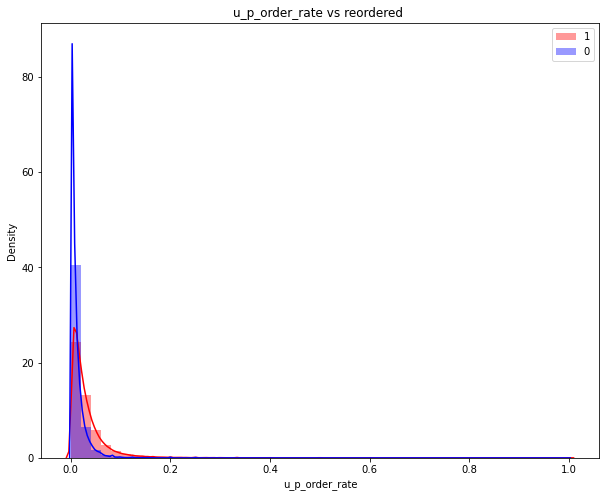

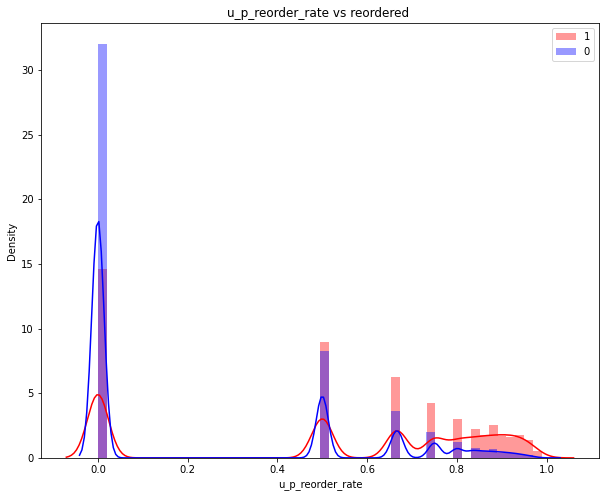

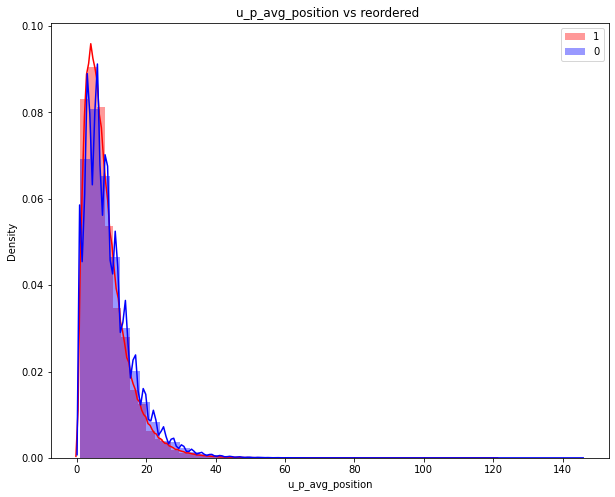

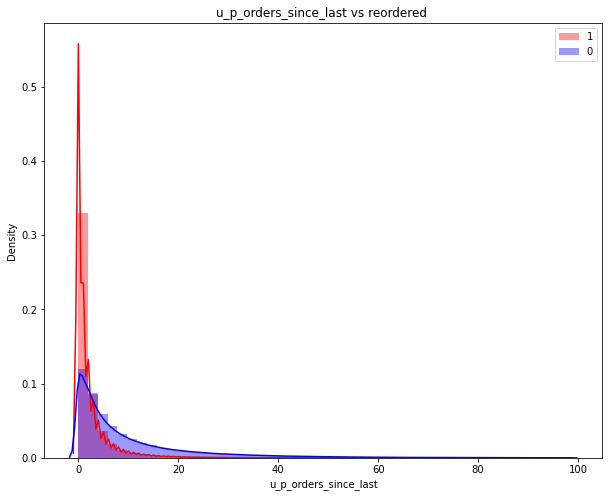

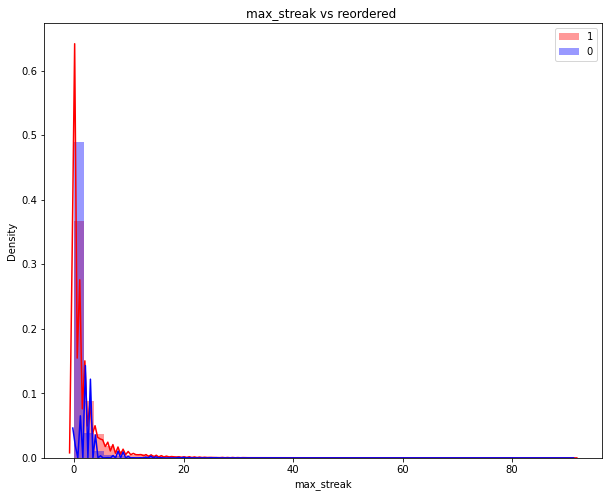

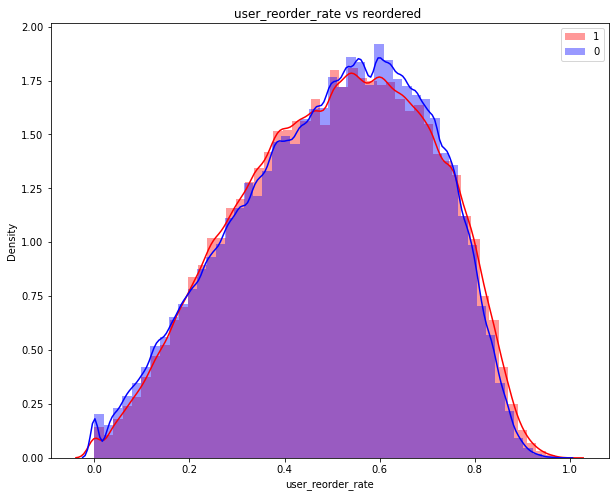

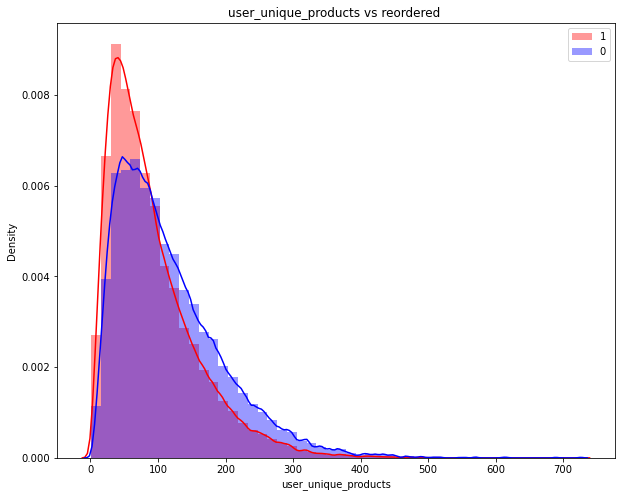

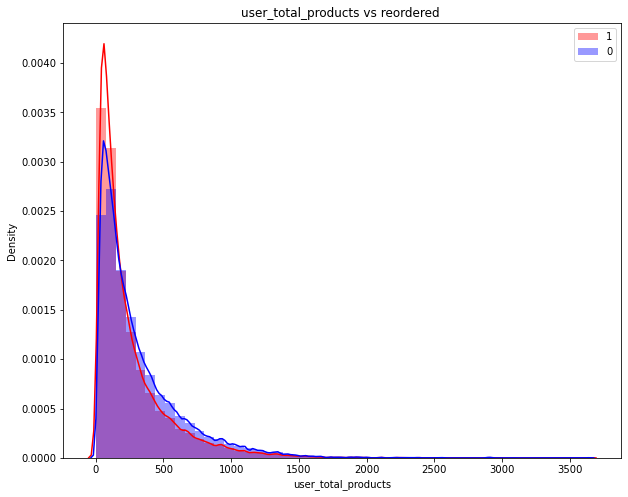

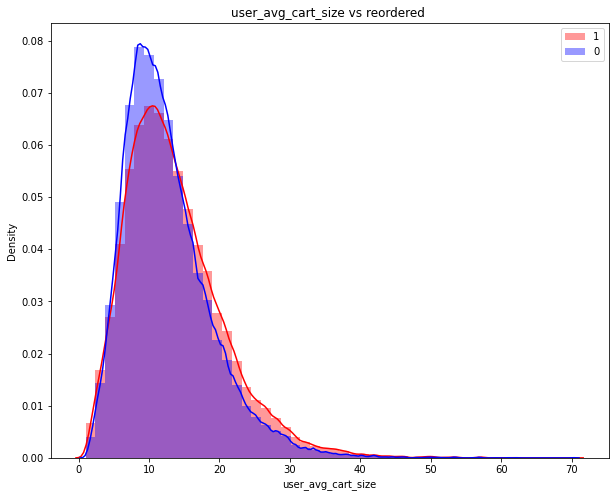

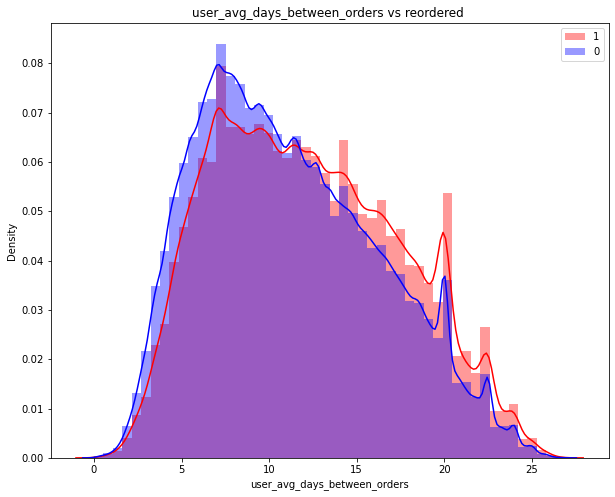

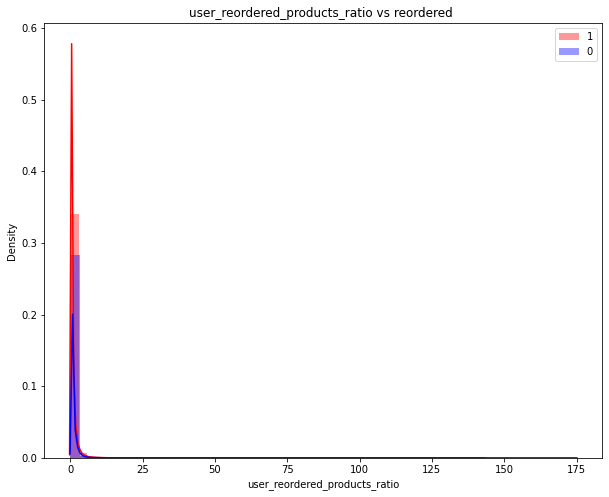

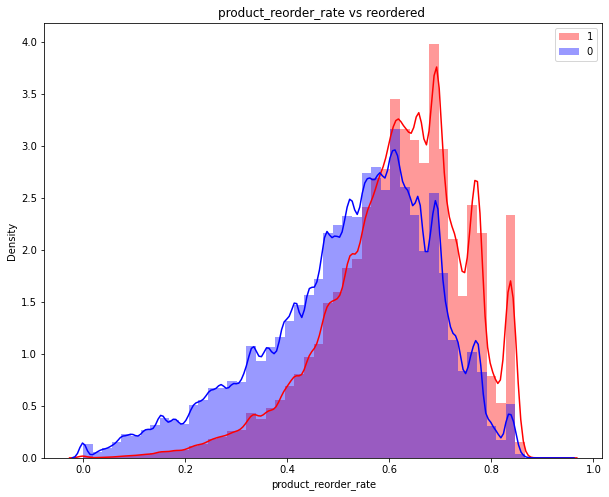

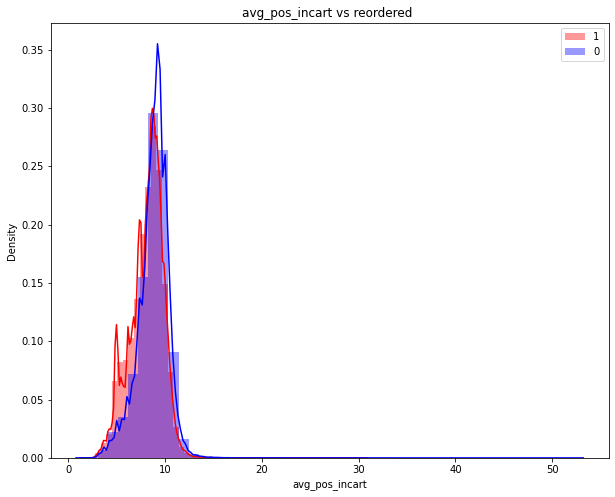

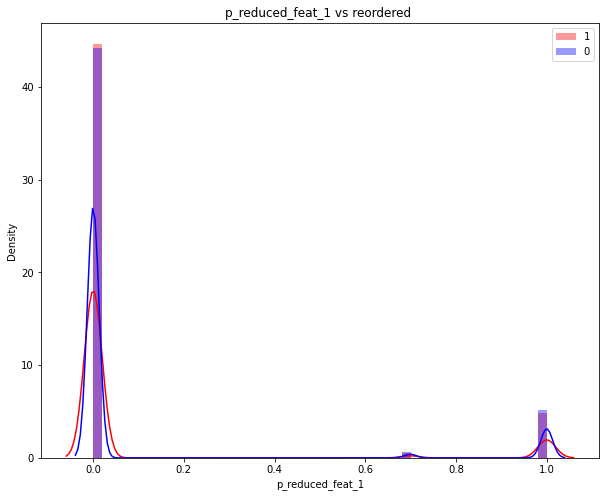

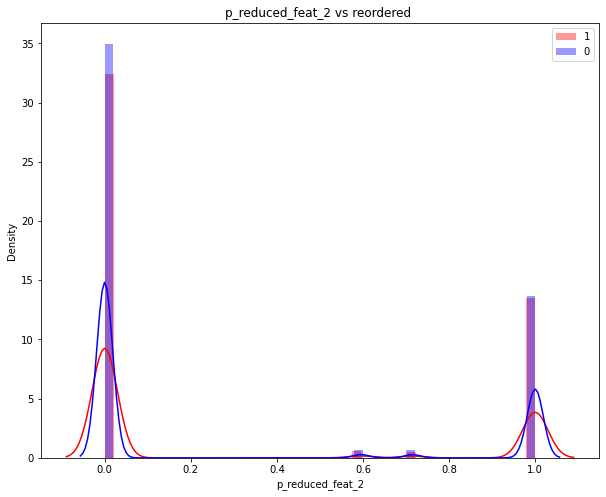

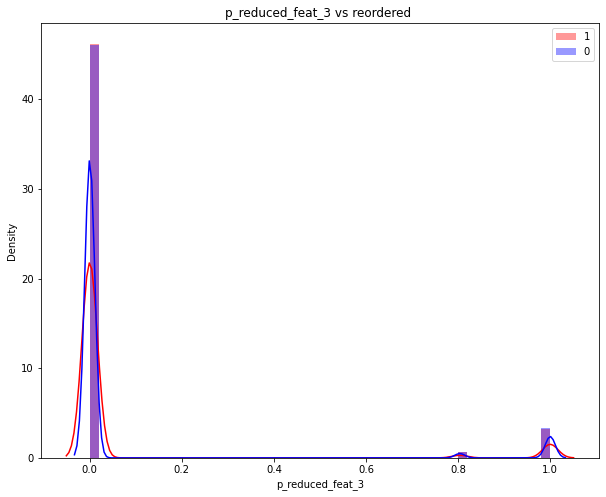

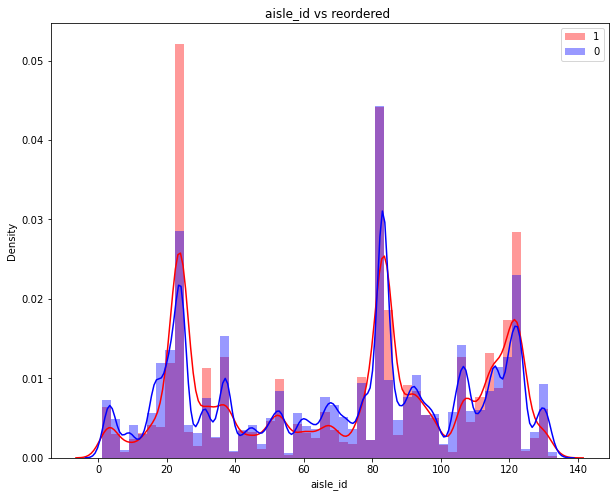

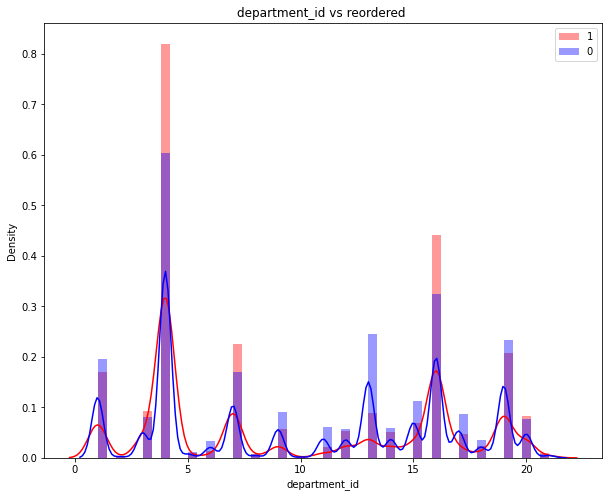

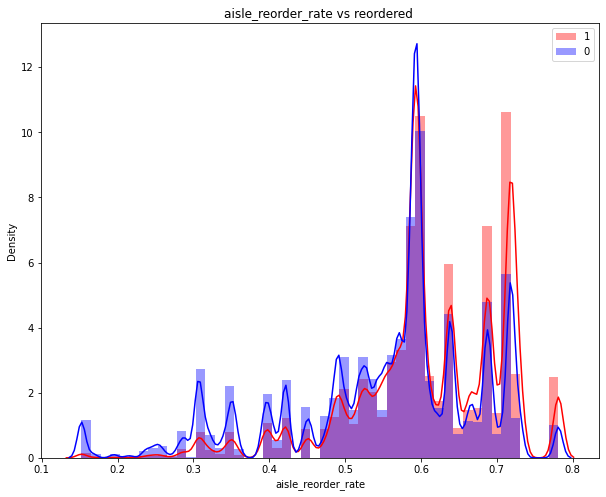

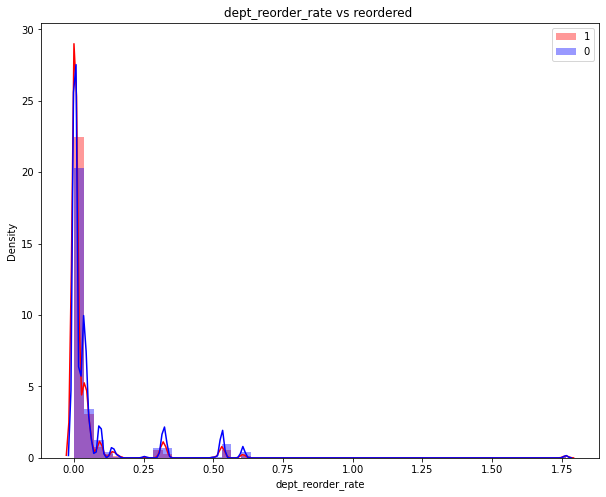

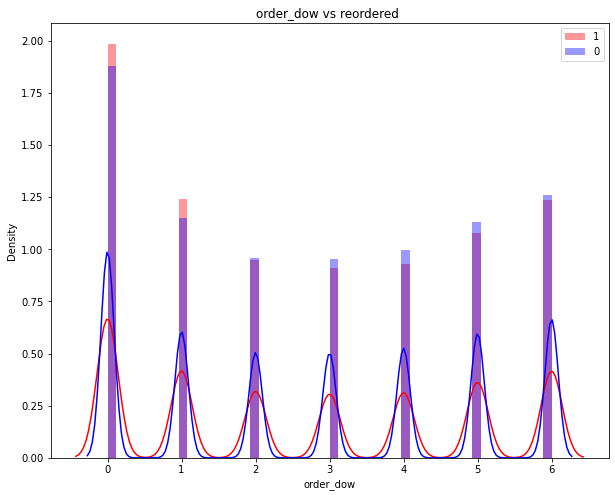

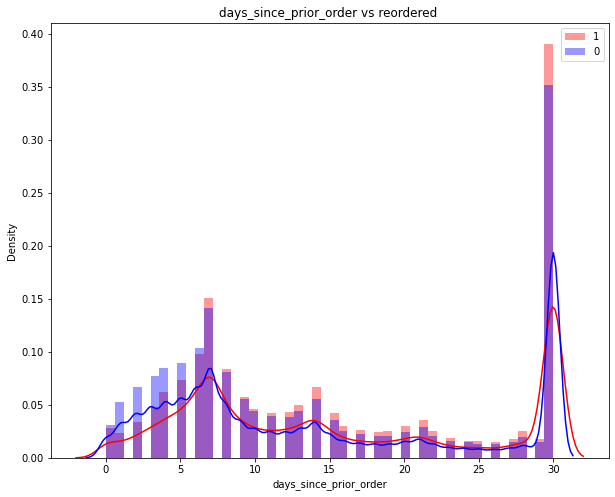

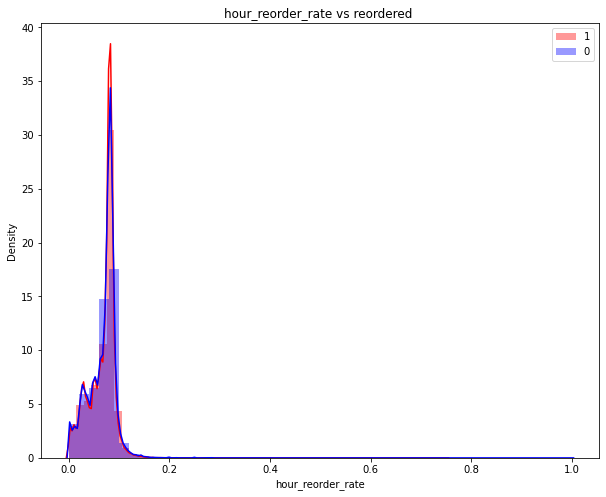

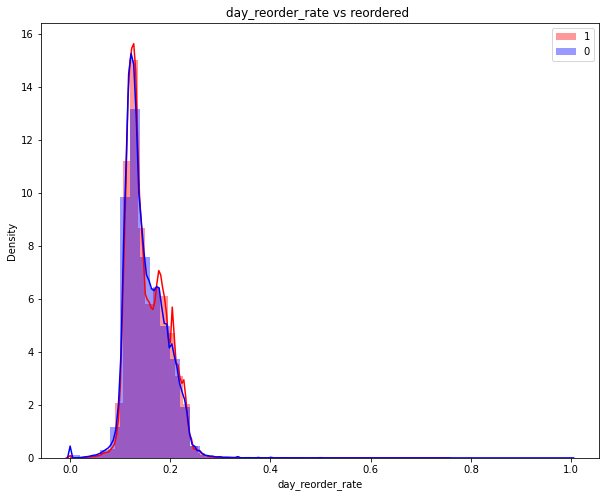

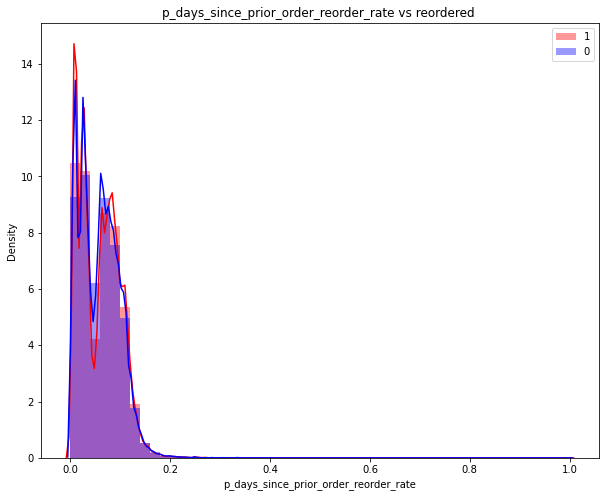

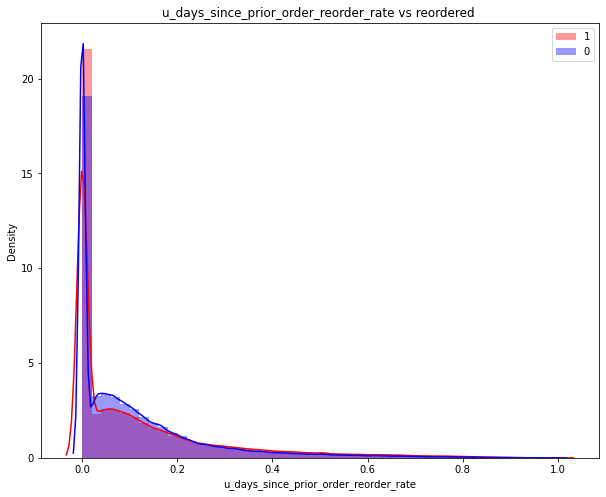

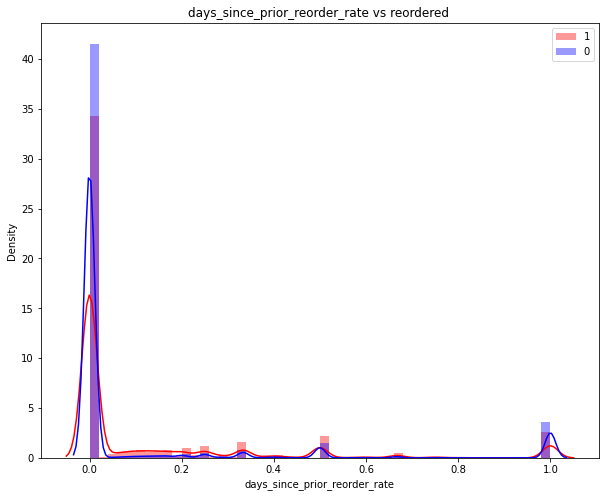

In [51]:
for i in cols:
    plt.figure(figsize=(10, 8))
    sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
    sns.distplot(df[df['reordered'] == 0.0][i] , label = "0" , color = 'blue' )
    plt.legend()
    plt.title(str(i) + " vs reordered ")
    plt.show()

As seen from above plot,
- these features will contribute to our classification problem,
- though not heavily, but will add some value to the model.
- we can remove these features anytime, after we build our model and check feature importances